The aim here is to compare the recovery (in terms of average summed synapse strength onto excitatory cells and firing rate distributions of excitatory cells) of a network of HVC RA-projectors and interneurons following a 50% perturbation of the RA-projectors.

Here, we compare the recovery under 3 distinct sets of plasticity rules:

1. burst timing-dependent plasticity + single-cell firing rate upper bound + population-level firing rate rule
2. burst timing-dependent plasticity + single-cell firing rate (asym about setpoint)
3. burst timing-dependent plasticity + population-level firing rate rule

In [116]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

%matplotlib inline
from copy import deepcopy as copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
from scipy import stats
import scipy.io as sio
import pandas as pd
import pickle
from collections import OrderedDict
from scipy.ndimage.interpolation import shift
from functools import reduce
import time
import re
from scipy.special import comb
import time
import asyncio
from bisect import bisect_left

from aux import Generic, bin_occurrences, safe_apply_stat, flatten
from disp import set_font_size, get_spaced_colors, graph_weight_matrix
from ntwk import LIFNtwkG
from utils.general import *
from utils.file_io import *

dt = 0.22e-3

In [117]:
def save_fig(fig, path, name):
    if not os.path.exists(path):
        os.makedirs(path)
    fig.savefig(os.path.join(path, name))

In [118]:
def get_equally_spaced_colors(n, cmap='autumn'):
    cmap = plt.get_cmap(cmap)
    colors = cmap(np.linspace(0, 1, n))
    return [matplotlib.colors.rgb2hex(rgba) for rgba in colors]

In [119]:
def process_single_activation(exc_raster, n):
    # extract first spikes
    first_spk_times = np.nan * np.ones(n)
    for i in range(exc_raster.shape[1]):
        nrn_idx = int(exc_raster[1, i])
        if np.isnan(first_spk_times[nrn_idx]):
            first_spk_times[nrn_idx] = exc_raster[0, i]
    return first_spk_times

In [120]:
def load_exp_data(direc, cut=None, layer_size=10, n_exc=1000, name_frags=[], reverse=False):
    file_names = [f for f in sorted(all_files_from_dir(direc))]
    file_names = [f for f in filter_list_by_name_frags(file_names, name_frags)]
    if cut is not None:
        file_names = file_names[:cut]
        
    included_cell_mask = None
    file_name_count = range(0, len(file_names))
    if reverse:
        file_name_count = reversed(file_name_count)
    for i_f in file_name_count:
        file = file_names[i_f]
        
        if i_f == 0:
            loaded = sio.loadmat(os.path.join(direc, file))
        
        def lazy_load():
            loaded = sio.loadmat(os.path.join(direc, file))

            exc_raster = loaded['exc_raster']
            inh_raster = loaded['inh_raster']

            first_spk_times = process_single_activation(loaded['exc_raster'].astype(float), n_exc)

            layers_active = []
            layer_weights = []

            data = {
                'index': i_f,
                'first_spk_times': first_spk_times,
                
                'w_e_e': loaded['w_e_e'][0],
                'w_e_i': loaded['w_e_i'][0],
                'w_i_e': loaded['w_i_e'][0],
                
                'exc_raster': exc_raster,
                'inh_raster': inh_raster,
                'freqs': loaded['freqs'][0],
                'spk_bins': loaded['spk_bins'][0],
                
                'prop_speed': loaded['prop_speed'][0],
                'avg_temporal_width': loaded['avg_temporal_width'][0],
                'stable': loaded['stable'][0],
            }
            if 'gs' in loaded:
                data['gs'] = loaded['gs']
                
            if 'w_r_e' in loaded:
                data['w_r_e'] = loaded['w_r_e']
                data['w_r_i'] = loaded['w_r_i']
                
#             if 'surviving_cell_indices' in loaded:
#                 surviving_cell_indices = loaded['surviving_cell_indices'][0, :]
#                 data['surviving_cell_indices'] = surviving_cell_indices
                
#                 sorting_order = np.argsort(exc_raster[1, :])
#                 exc_raster_sorted = exc_raster[:, sorting_order]
#                 indices = np.arange(len(surviving_cell_indices))[surviving_cell_indices.astype(bool)]
                
#                 exc_raster_unperturbed = []
#                 exc_raster_perturbed = []
                
#                 j = 0
#                 for idx in np.arange(exc_raster_sorted.shape[1]):
#                     if j >= len(indices):
#                         exc_raster_perturbed.append(exc_raster_sorted[:, idx].reshape(2, 1))
#                     elif exc_raster_sorted[1, idx] < indices[j]:
#                         exc_raster_perturbed.append(exc_raster_sorted[:, idx].reshape(2, 1))
#                     elif exc_raster_sorted[1, idx] == indices[j]:
#                         exc_raster_unperturbed.append(exc_raster_sorted[:, idx].reshape(2, 1))
#                     elif exc_raster_sorted[1, idx] > indices[j]:
#                         j +=1
                
#                 data['exc_raster_unperturbed'] = np.concatenate(exc_raster_unperturbed, axis=1)
#                 data['exc_raster_perturbed'] = np.concatenate(exc_raster_perturbed, axis=1)
                
            return data
        yield i_f, lazy_load

In [121]:
def make_heat_map(mat):
    scale = 7
    cbar_frac = 0.1
    fig = plt.figure(constrained_layout=True, figsize=(scale, scale))
    graph_col_width = int(1 / cbar_frac)
    gs = gridspec.GridSpec(ncols=graph_col_width, nrows=1, figure=fig)
    axs = [
        fig.add_subplot(gs[0: graph_col_width - 1]),
        fig.add_subplot(gs[graph_col_width - 1]),
    ]
    
    print(mat[~np.isnan(mat)].min())
    print(mat[~np.isnan(mat)].max())

    im1 = axs[0].imshow(mat, cmap='YlOrRd', vmin=mat[~np.isnan(mat)].min(), vmax=mat[~np.isnan(mat)].max())
    plt.colorbar(im1, cax=axs[1])
    
    return axs, fig

In [130]:
def make_maps(name, shape, repeats=1):
    if type(name) is list:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), name)
    else:
        all_dirs = filter_list_by_name_frags(all_in_dir('./robustness'), [name])
        
    all_dirs = [d for d in all_dirs]
    n_points = len(all_dirs)
    
    prop_speeds = np.zeros(n_points)
    avg_temporal_widths = np.zeros(n_points)
    stability_points = np.zeros(n_points)
    
    for d_idx, exp_dir_name in enumerate(sorted(all_dirs)):
        try:
            load_data = [d for i_d, d in load_exp_data(os.path.join('./robustness', exp_dir_name))][0]
        except IndexError:
            continue
        data = load_data()
        first_spk_times = data['first_spk_times']
        prop_speed = data['prop_speed']
        avg_temporal_width = data['avg_temporal_width']
        
#         print(data['w_e_e'])
#         print(data['w_i_e'])
#         print(prop_speed)
#         print(avg_temporal_width)
#         print('')
        
        stable = len(~np.isnan(first_spk_times[950:1000])) > 30
        
        prop_speeds[d_idx] = prop_speed
        avg_temporal_widths[d_idx] = avg_temporal_width
        stability_points[d_idx] = stable
        
        if stable == 0 or np.isnan(prop_speed) or np.isnan(avg_temporal_width):
            prop_speeds[d_idx] = np.nan
            avg_temporal_widths[d_idx] = np.nan
            stability_points[d_idx] = 0
            
    fig = plt.figure(constrained_layout=True, figsize=(8, 8))
    gs = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
    ax = fig.add_subplot(gs[0])
    
    to_show_mask = np.logical_and(~np.isnan(prop_speeds), ~np.isclose(prop_speeds, 0))
    ax.scatter(avg_temporal_widths[to_show_mask], prop_speeds[to_show_mask], s=2, c='black')
    ax.set_ylabel('Prop Speed')    
    ax.set_xlabel('Avg Temporal Width')
    
    prop_speeds = np.array([np.mean(prop_speeds[l:l+repeats]) for l in range(0, n_points, repeats)])
    avg_temporal_widths = np.array([np.mean(avg_temporal_widths[l:l+repeats]) for l in range(0, n_points, repeats)])
    stability_points = np.array([np.mean(stability_points[l:l+repeats]) for l in range(0, n_points, repeats)])
    
    prop_speeds_all = np.nan * np.ones(shape)
    avg_temporal_widths_all = np.nan * np.ones(shape)
    stability_points_all = np.nan * np.ones(shape)
    
    for i in range(len(prop_speeds)):
        j = int(i / shape[0])
        k = i % shape[0]
        prop_speeds_all[j, k] = prop_speeds[i]
        avg_temporal_widths_all[j, k] = avg_temporal_widths[i]
        stability_points_all[j, k] = stability_points[i]
    
    ax1, f1 = make_heat_map(prop_speeds_all.T)
    ax1[0].set_title('Prop speeds\n')
    
    ax2, f2 = make_heat_map(avg_temporal_widths_all.T)
    ax2[0].set_title('Avg temporal std of spikes\n')
    
    ax3, f3 = make_heat_map(stability_points_all.T)
    ax3[0].set_title('Stablility\n')
    
    for ax in [ax1, ax2, ax3]:
        ax[0].set_ylabel('w_i_e')
        ax[0].set_xlabel('w_e_e')
        

227.13077054113907
240.30951866003414
0.0016443489582047624
0.0028623970068582753
0.0
1.0


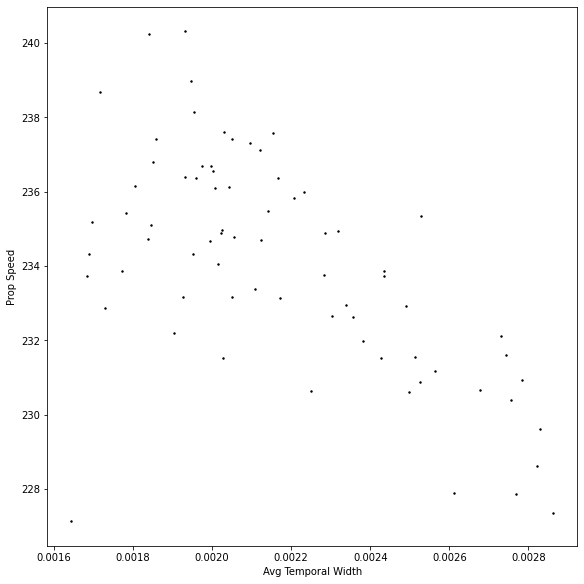

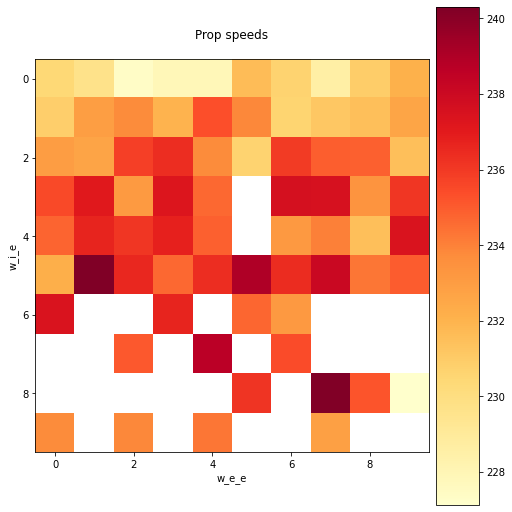

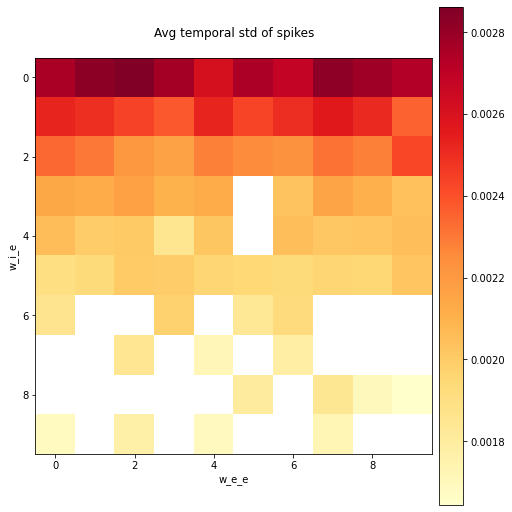

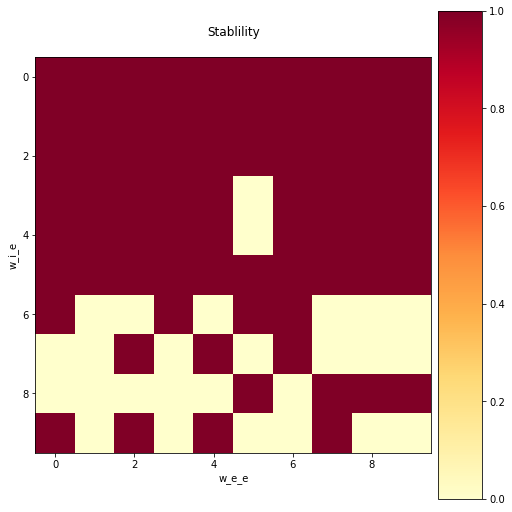

In [131]:
make_maps(['w_e_i_7e-5_', '2022-04-06--12:'], (10, 10))

219.5339792139974
236.6011947936093
0.0018504804078434364
0.005125227276491869
0.0
1.0


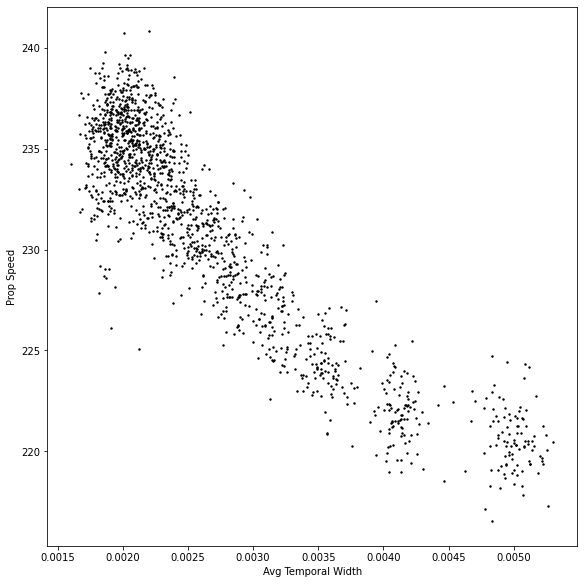

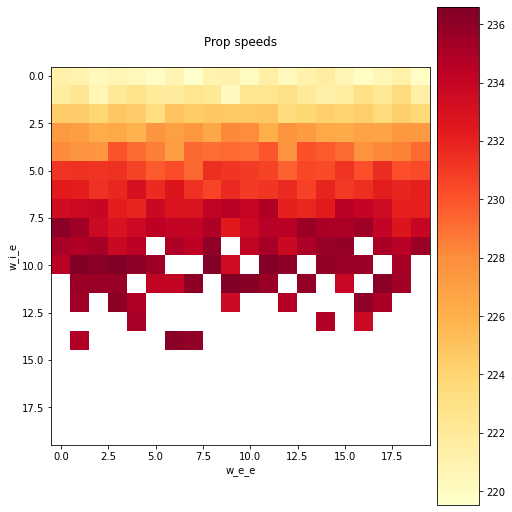

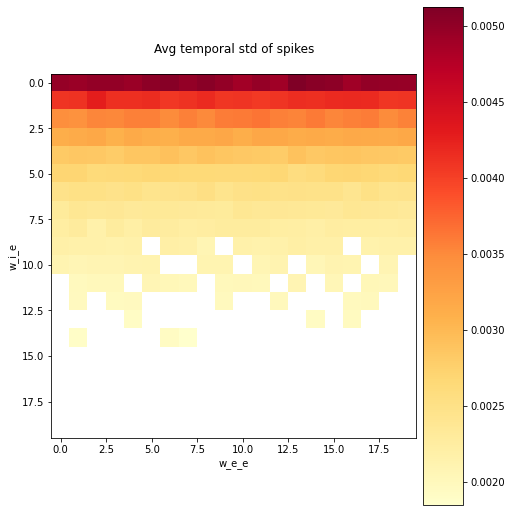

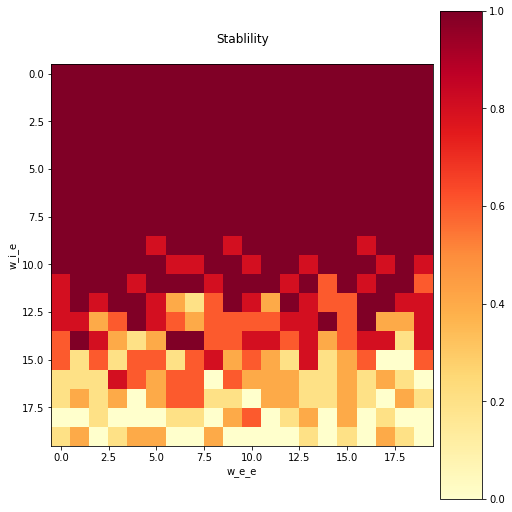

In [132]:
make_maps(['2nd_w_e_i_7e-5_'], (20, 20), repeats=5)

218.69016141368766
237.61249404215687
0.0018487099215011634
0.0051724906751771296
0.0
1.0


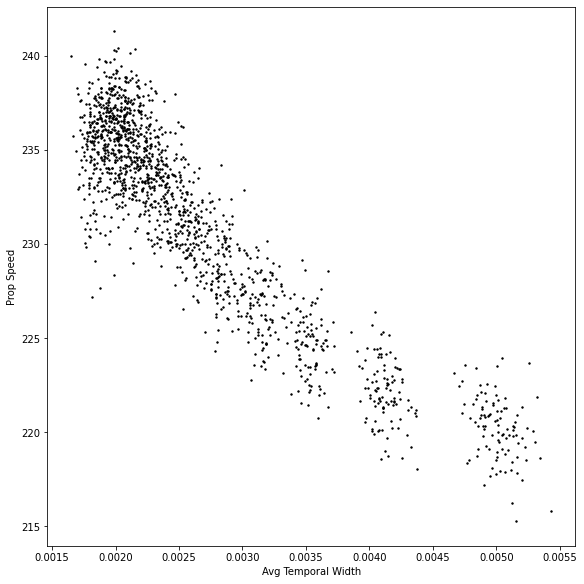

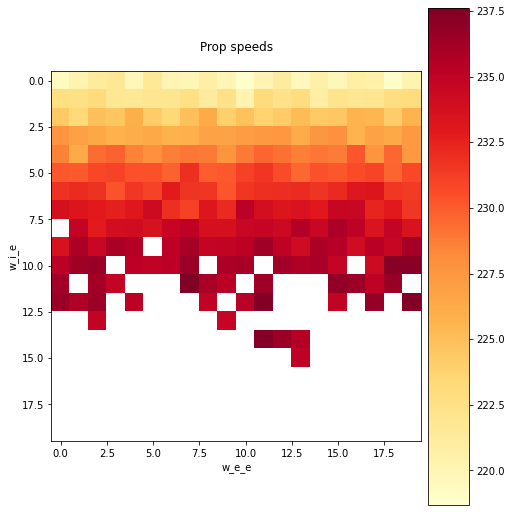

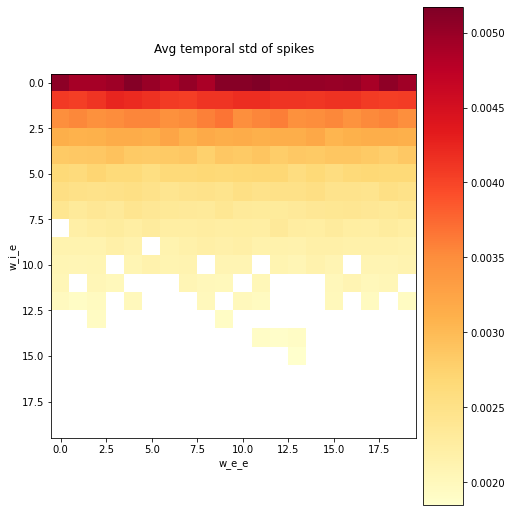

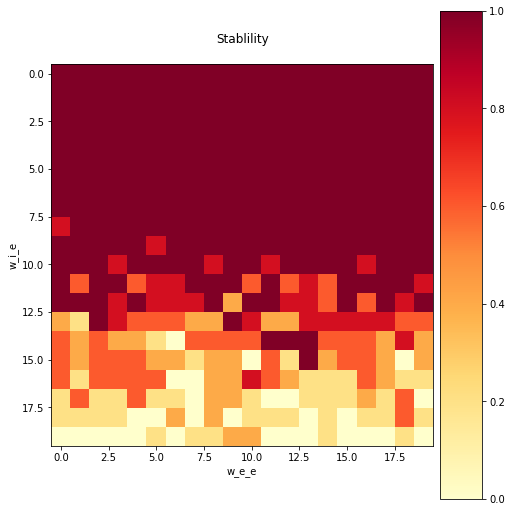

In [133]:
make_maps(['3rd_w_e_i_7e-5_'], (20, 20), repeats=5)